In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Define transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


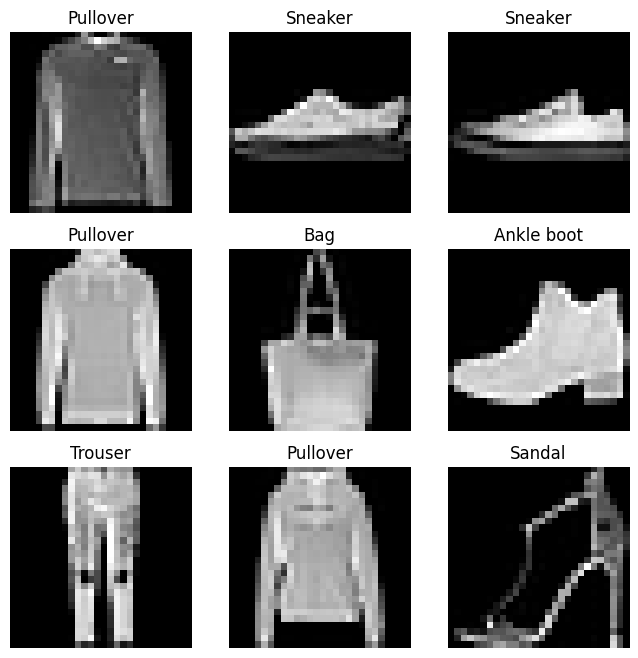

In [5]:
labels_map = {
    0: 'T-shirt/top',
    1:'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
len(training_data)

60000

In [7]:
# Assuming trainset is your dataset
data = training_data.data.numpy()
labels = training_data.targets.numpy()

df = pd.DataFrame({'Imxage Data': list(data), 'Label': list(labels)})

print(df.head())


                                         Imxage Data  Label
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      9
1  [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, ...      0
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0...      0
3  [[0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64...      3
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      0


In [8]:

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, pin_memory= True, drop_last=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory= True, drop_last=True)


In [9]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #increased filters, smaller kernel
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 1 * 1, 512) #increased neurons
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

          # Debugging: Check the shape before flattening

        x = x.view(x.size(0), 256 * 1 * 1)  # Dynamic flattening
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [10]:

model = Net()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model.to(device)


Using device: cuda


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=1

In [12]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

epochs = 30
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_dataloader))


    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}")



Epoch 1, Train Loss: 0.2800
Epoch 2, Train Loss: 0.2462
Epoch 3, Train Loss: 0.2258
Epoch 4, Train Loss: 0.2131
Epoch 5, Train Loss: 0.2015
Epoch 6, Train Loss: 0.1930
Epoch 7, Train Loss: 0.1857
Epoch 8, Train Loss: 0.1770
Epoch 9, Train Loss: 0.1690
Epoch 10, Train Loss: 0.1656
Epoch 11, Train Loss: 0.1601
Epoch 12, Train Loss: 0.1547
Epoch 13, Train Loss: 0.1527
Epoch 14, Train Loss: 0.1484
Epoch 15, Train Loss: 0.1460
Epoch 16, Train Loss: 0.1401
Epoch 17, Train Loss: 0.1378
Epoch 18, Train Loss: 0.1356
Epoch 19, Train Loss: 0.1334
Epoch 20, Train Loss: 0.1342
Epoch 21, Train Loss: 0.1317
Epoch 22, Train Loss: 0.1259
Epoch 23, Train Loss: 0.1251
Epoch 24, Train Loss: 0.1248
Epoch 25, Train Loss: 0.1222
Epoch 26, Train Loss: 0.1225
Epoch 27, Train Loss: 0.1205
Epoch 28, Train Loss: 0.1189
Epoch 29, Train Loss: 0.1188
Epoch 30, Train Loss: 0.1186


In [13]:
torch.save(model, 'Saved_model.pth')

In [17]:
saved_model = torch.load('Saved_model.pth', weights_only=False)

In [18]:

saved_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():  # Disable gradient calculation for evaluation
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
accuracy = 100 * correct / total
print(f"Accuracy of the network on the {total} test images: {accuracy:.2f} %")
for i in range(len(classes)):
    class_accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] else 0
    print(f"Accuracy of {classes[i]}: {class_accuracy:.2f} %")


Accuracy of the network on the 9984 test images: 91.31 %
Accuracy of T-shirt/top: 81.80 %
Accuracy of Trouser: 97.79 %
Accuracy of Pullover: 89.69 %
Accuracy of Dress: 89.09 %
Accuracy of Coat: 83.28 %
Accuracy of Sandal: 98.70 %
Accuracy of Shirt: 81.58 %
Accuracy of Sneaker: 96.60 %
Accuracy of Bag: 97.99 %
Accuracy of Ankle boot: 96.59 %


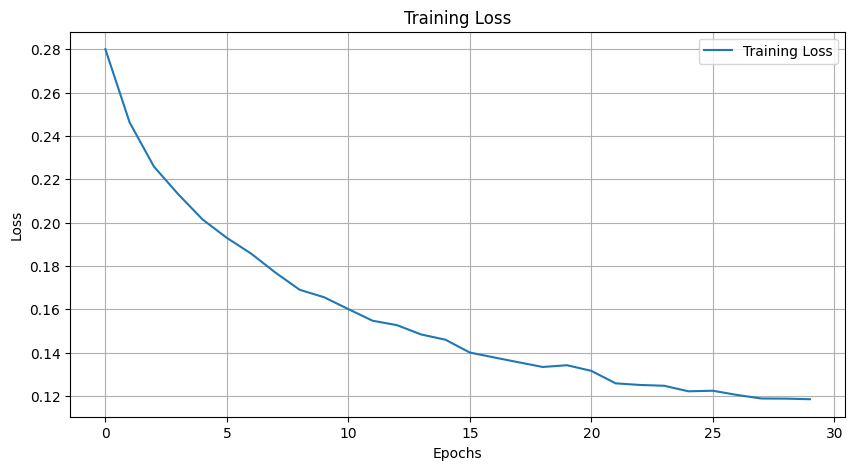

In [19]:


def plot_loss(train_losses):
    """Plots the training loss over epochs."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(train_losses)


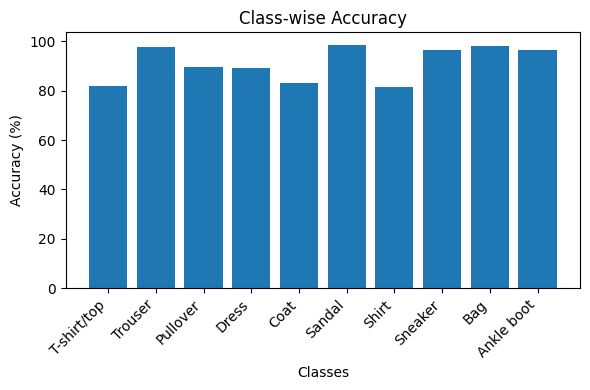

In [20]:

# Plotting Function
def plot_class_accuracy(classes, class_correct, class_total):
    """Plots the class-wise accuracy."""
    accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] else 0 for i in range(10)]
    plt.figure(figsize=(6, 4))
    plt.bar(classes, accuracies)
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy')
    plt.xticks(rotation=45, ha='right')  # Rotate class labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

plot_class_accuracy(classes, class_correct, class_total)


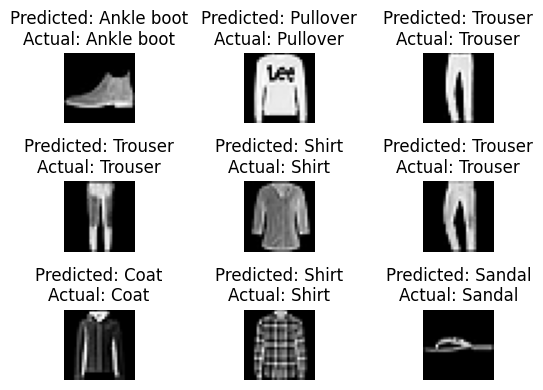

In [21]:

def plot_random_predictions(model, test_dataloader, classes, device, num_images=9):
    """Plots random test images with predicted and actual labels."""
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(test_dataloader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(6, 4))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        img = images[i].cpu().squeeze()
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicted: {classes[predicted[i]]}\nActual: {classes[labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_random_predictions(model, test_dataloader, classes, device)